## Testing of field curvature
### Imaging setup:
- Objective: Nikkor 85 mm lense, with full open aperture iris, and mag 2x (extension rings 36 + 36 + 12 = 84mm)
- Lens orientation seems to matter a lot - orient it relative to long sensor axis the same way it is on DSLR camera. Incorrect orientation produces low-contast areas at the edges of the sensor's longer exis.
- Camera: Photometrics Iris 15
- Test sample: Ronchi grating (e.g. 40 lp/mm from Thorlabs) imaged at different focus position (stack).
- Illumination: even background using a smartphone screen (all white, 50-70% intensity)

MTF is accessed across field of view via local contrast metric.

Inspired by Roger Cicala's [blog post](https://www.lensrentals.com/blog/2018/06/developing-a-rapid-mtf-test-for-photo-and-video-lenses/).

Imaging with exposure time > 100 ms to minimize flickering from smartphone screen.

- Author: Nikita Vladimirov 
- License: GPL-3.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import tifffile as tif
import glob, os
from pathlib import Path

### Explore TIFF stack of a Ronchi grid at different F-position

In [18]:
datafolder = "D:\\benchtopData\\Lens-testing\\"
LENS_NAME = "Nikon Micro 85mm"
zoom_key = "2x_fullNA"
datafiles = {
    "2x_fullNA": datafolder + "\\NikonMicro85mm\\2022-06-21-NikonMicro85mm-Mag2x-fullNA\\one.tif"
}

MAG = float(zoom_key[:1]) # Effective lens magnification

save_figs_folder = ".\\NikonMicro85mm-figs\\"

f_step_um = 10 # focus step between planes
CAMERA = "Photometrics Iris 15"
sensor_dim_mm = (21.49, 12.61) # Iris 15

# The number of ROIs to divide image along each axis
#these give integer number of rois along each axis, with aspect ratio close to the sensor ratio
N_ROIs_H, N_ROIs_W = 32, 20 # Iris 15
#N_ROIs_H, N_ROIs_W = 16, 16 # Orca Flash 4

In [19]:
img = tif.imread(datafiles[zoom_key])
im_z, im_h, im_w = img.shape
print(im_z, im_h, im_w)
print(f"Aspect ratio {im_w/im_h}")
assert img.max() < 65535, "Error: image is saturated"

61 5056 2960
Aspect ratio 0.5854430379746836


In [20]:
roi_h, roi_w = int(im_h/N_ROIs_H), int(im_w/N_ROIs_W)
print(roi_h, roi_w)

158 148


Text(0.5, 1.0, 'ROI in the stack center')

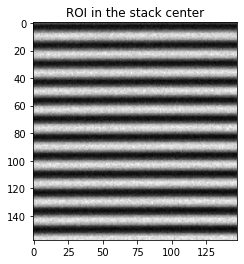

In [21]:
roi = img[im_z//2, roi_h*(N_ROIs_H//2 - 1): roi_h*(N_ROIs_H//2), 
               roi_w*(N_ROIs_W//2 - 1) : roi_w*(N_ROIs_W//2)]
plt.imshow(roi, cmap='gray')
plt.title("ROI in the stack center")

In [22]:
def contrast(roi):
    """Compute the contrast value, (max-min)/(max+min), from the image roi"""
    mini = np.percentile(roi, 1)
    maxi = np.percentile(roi, 99)
    contrast = (maxi - mini) / (maxi + mini)
    return contrast

In [23]:
contrast_table = np.empty((im_z, N_ROIs_H, N_ROIs_W))
for f in range(im_z):
    for j in range(N_ROIs_H):
        for i in range(N_ROIs_W):
            roi = img[f,j*roi_h:(j+1)*roi_h, i*roi_w:(i+1)*roi_w]
            contrast_table[f,j,i] = contrast(roi)

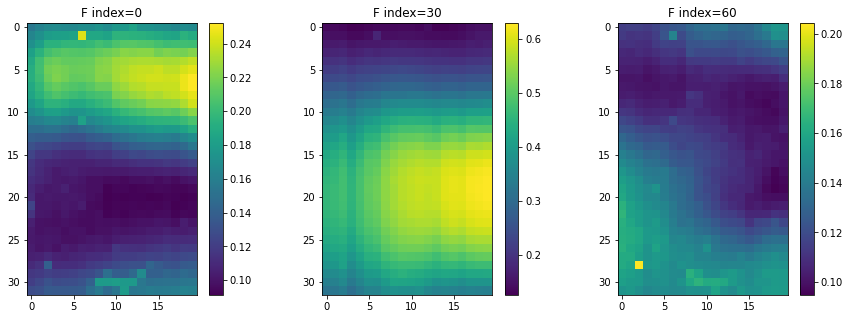

In [24]:
fig = plt.figure(figsize=(15, 5))
for ind, f in enumerate([0, im_z//2, im_z-1]):
    ax = plt.subplot(1, 3, ind+1)
    conmap = ax.imshow(contrast_table[f,:,:])
    ax.set_title("F index=" + str(f))
    plt.colorbar(conmap,ax=ax)

In [25]:
# Save contrast table as TIFF and explore interactively
tif.imsave(save_figs_folder + zoom_key + "_contrast.tiff", contrast_table)

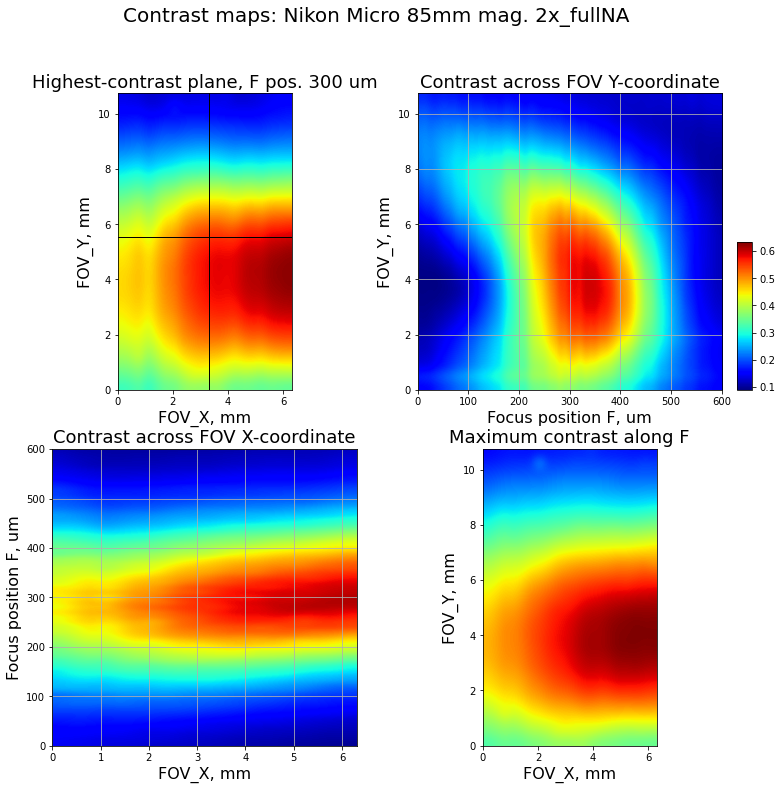

In [26]:
# slice the contrast map along XZ and YZ axis, therough the center
section_plane_x = N_ROIs_W//2
section_plane_y = N_ROIs_H//2
contrast_yz = np.squeeze(contrast_table[:,:,section_plane_x])
contrast_xz = np.squeeze(contrast_table[:,section_plane_y,:])
z_contrast_max = np.argmax(contrast_table[:,section_plane_y,section_plane_x])
cmin, cmax = contrast_table.min(), contrast_table.max()
y_range = np.linspace(0, sensor_dim_mm[0], N_ROIs_H) / MAG
x_range = np.linspace(0, sensor_dim_mm[1], N_ROIs_W) / MAG
f_range = np.linspace(0, f_step_um*(im_z-1), im_z)

fig = plt.figure(figsize=(12, 12))
fig.suptitle(f'Contrast maps: {LENS_NAME} mag. {zoom_key}', fontsize=20)

ax1 = plt.subplot(2, 2, 1)
ax1.imshow(contrast_table[z_contrast_max,:,:], vmin=cmin, vmax=cmax,
                     extent=[0, x_range[-1], 0, y_range[-1]], 
                     aspect='equal', cmap='jet', interpolation='bicubic')
ax1.set_title(f"Highest-contrast plane, F pos. {z_contrast_max*f_step_um} um", fontsize=18)
ax1.set_xlabel("FOV_X, mm", fontsize=16)
ax1.set_ylabel("FOV_Y, mm", fontsize=16)
ax1.axhline(y_range[section_plane_y], c="black", linewidth=1)
ax1.axvline(x_range[section_plane_x], c="black", linewidth=1)

ax3 = plt.subplot(2, 2, 2)
conmap3 = ax3.imshow(contrast_yz.T, vmin=cmin, vmax=cmax,
                     extent=[0, f_step_um*(im_z-1), 0, y_range[-1]], 
                     aspect='auto', cmap='jet', interpolation='bicubic')
ax3.set_title("Contrast across FOV Y-coordinate", fontsize=18)
ax3.set_xlabel("Focus position F, um", fontsize=16)
ax3.set_ylabel("FOV_Y, mm", fontsize=16)
ax3.grid(True)

ax4 = plt.subplot(2, 2, 3)
conmap1 = ax4.imshow(contrast_xz, vmin=cmin, vmax=cmax,
                     extent=[0, x_range[-1], 0, f_step_um*(im_z-1)], 
                     aspect='auto', cmap='jet', interpolation='bicubic')
ax4.set_title("Contrast across FOV X-coordinate", fontsize=18)
ax4.set_ylabel("Focus position F, um", fontsize=16)
ax4.set_xlabel("FOV_X, mm", fontsize=16)
ax4.grid(True)

ax0 = plt.subplot(2, 2, 4)
conmap0 = ax0.imshow(contrast_table.max(axis=0), vmin=cmin, vmax=cmax,
                     extent=[0, x_range[-1], 0, y_range[-1]], 
                     aspect='equal', cmap='jet', interpolation='bicubic')
ax0.set_title("Maximum contrast along F", fontsize=18)
ax0.set_xlabel("FOV_X, mm", fontsize=16)
ax0.set_ylabel("FOV_Y, mm", fontsize=16)

axins = inset_axes(ax3,
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )
plt.colorbar(conmap0, cax=axins)

In [27]:
fig.savefig(save_figs_folder + zoom_key + "_contrast_map.png")

Sag across FOV_X: 12 um
Sag across FOV_Y: 166 um
DOF (um), by gaussian fitting fwhm: 280


Text(0.1, 0.3, 'Sag across FOV_Y: 166 um')

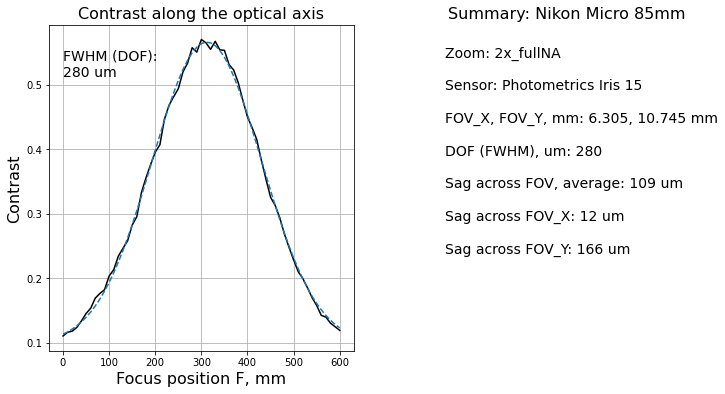

In [28]:
import lib.optimization as opt # custom-made optimization library

# gaussian fit of contrast profile along the optical axis
fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,N_ROIs_W//2], f_range)

# Find curvature sag across FOV_X: find peak contrast at the section start and end points
fit_center_left,  _, _, _ = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,0], f_range)
fit_center_right,  _, _, _ = opt.fit_gaussian_1d(contrast_table[:,N_ROIs_H//2,-1], f_range)

# Find curvature sag across FOV_Y:
fit_center_down, _, _, _ = opt.fit_gaussian_1d(contrast_table[:,0,N_ROIs_W//2], f_range)
fit_center_up, _, _, _ = opt.fit_gaussian_1d(contrast_table[:,-1,N_ROIs_W//2], f_range)

# Average the start, middle, end positions of the peak contrast
sag_x = abs(round(fit_center - 0.5*(fit_center_left + fit_center_right)))
sag_y = abs(round(fit_center - 0.5*(fit_center_up + fit_center_down)))
ave_sag = (sag_x * x_range[-1] + sag_y * y_range[-1]) / (x_range[-1] + y_range[-1])
dof = round(opt.sigma2fwhm(fit_sigma))
print(f"Sag across FOV_X: {sag_x} um")
print(f"Sag across FOV_Y: {sag_y} um")
print(f"DOF (um), by gaussian fitting fwhm: {dof}")


fig = plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(f_range, contrast_table[:,N_ROIs_H//2,N_ROIs_W//2], '-k')
ax1.plot(f_range, opt.gaussian_1d(f_range, fit_center, fit_sigma, fit_amp, fit_offset),'--')
ax1.text(0,0.9*contrast_table[:,N_ROIs_H//2,N_ROIs_W//2].max(),f"FWHM (DOF): \n{dof} um", fontsize=14)
ax1.set_title("Contrast along the optical axis", fontsize=16)
ax1.set_xlabel("Focus position F, mm", fontsize=16)
ax1.set_ylabel("Contrast", fontsize=16)
ax1.grid(True)

ax2 = plt.subplot(1, 2, 2)
ax2.axis('off')
ax2.set_title(f"Summary: {LENS_NAME}", fontsize=16)
ax2.text(0.1, 0.9, f"Zoom: {zoom_key}", fontsize=14) 
ax2.text(0.1, 0.8, f"Sensor: {CAMERA}", fontsize=14)
ax2.text(0.1, 0.7, f"FOV_X, FOV_Y, mm: {x_range[-1]:.3f}, {y_range[-1]:.3f} mm", fontsize=14)
ax2.text(0.1, 0.6, f"DOF (FWHM), um: {dof}", fontsize=14)
ax2.text(0.1, 0.5, f"Sag across FOV, average: {round(ave_sag)} um", fontsize=14)
ax2.text(0.1, 0.4, f"Sag across FOV_X: {sag_x} um", fontsize=14)
ax2.text(0.1, 0.3, f"Sag across FOV_Y: {sag_y} um", fontsize=14)

In [29]:
fig.savefig(save_figs_folder + zoom_key + "_contrast_plot.png")

### Summary
- the field curvature is too strong and asymmetric
- contrast is higher that at 1x (0.6 vs 0.4)